<a href="https://colab.research.google.com/github/ju-mava/analisis-sentimiento-trabajo-final-p4/blob/main/A5_Machetti_Vallverd%C3%BA_J%C3%BAlia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

En esta práctica, aprenderemos a utilizar a hacer aprendizaje transferido (finetuning) con transformadores para realizar el análisis de sentimiento del dataset de Multilingual Amazon Reviews Corpus.

# Análisis, preprocesamiento y preparación de los datos

In [1]:
import pandas as pd

In [2]:
#Cargamos el dataset en CSV como un dataframe

sentiment140 = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding='latin-1', header=None)

In [3]:
# Asignar nombres a las columnas
sentiment140.columns = ['polarity', 'id', 'date', 'query', 'user', 'text']

In [4]:
# Muestreo estratificado para obtener 30.000 instancias manteniendo la proporción de clases
#Sobreescribimos el dataframe previo
sentiment140 = sentiment140.groupby('polarity', group_keys=False).apply(
    lambda x: x.sample(frac=30000/len(sentiment140), random_state=42)
).reset_index(drop=True)


<ipython-input-4-44688518cb3f>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sentiment140 = sentiment140.groupby('polarity', group_keys=False).apply(


In [5]:
from sklearn.model_selection import train_test_split

# División en entrenamiento y temp (validación + test)
train_sentiment140, temp_sentiment140 = train_test_split(sentiment140, test_size=0.2, random_state=42, stratify=sentiment140['polarity'])

# División de temp en validación y test
val_sentiment140, test_sentiment140 = train_test_split(temp_sentiment140, test_size=0.5, random_state=42, stratify=temp_sentiment140['polarity'])

In [6]:
# Ahora tenemos tres conjuntos
print(f"Train: {len(train_sentiment140)} muestras")
print(f"Validación: {len(val_sentiment140)} muestras")
print(f"Test: {len(test_sentiment140)} muestras")

Train: 24000 muestras
Validación: 3000 muestras
Test: 3000 muestras


Vamos a concatenar todos los splits del dataset en un único dataframe, en el que creamos una columna especificando si el split es el dataset de entrenamiento, de validación o de evaluación.

In [7]:
df_list = []

for df_split, split_name in [(train_sentiment140, "train"), (val_sentiment140, "dev"), (test_sentiment140, "test")]:
    df_split = df_split.copy()
    df_split["split"] = split_name
    df_list.append(df_split)

df = pd.concat(df_list)
df.head()

,polarity,id,date,query,user,text,split
12055,0,1975938702,Sat May 30 16:13:48 PDT 2009,NO_QUERY,natureboy2323,WOOOOOOOO! Guns N' Roses' Paradise City . Man...,train
13415,0,1754351563,Sun May 10 05:58:09 PDT 2009,NO_QUERY,pdurham,@icyjoey good! I wasn't gonna stop anyways......,train
18837,4,1557178160,Sun Apr 19 02:28:29 PDT 2009,NO_QUERY,LeanneBennett,"@PamDH My husband won't watch Grey's either, a...",train
25269,4,2063952152,Sun Jun 07 04:42:23 PDT 2009,NO_QUERY,KarZx,100 Updatess :O... Up thee rebelss x,train
20659,4,1964813383,Fri May 29 14:50:59 PDT 2009,NO_QUERY,MDOPrune,going to bed after BGT and HIGNFY. easy viewing,train


In [8]:
# Nos quedamos con las columnas que nos interesan
df = df[['text', 'polarity', 'split']]
df

,text,polarity,split
12055,WOOOOOOOO! Guns N' Roses' Paradise City . Man...,0,train
13415,@icyjoey good! I wasn't gonna stop anyways......,0,train
18837,"@PamDH My husband won't watch Grey's either, a...",4,train
25269,100 Updatess :O... Up thee rebelss x,4,train
20659,going to bed after BGT and HIGNFY. easy viewing,4,train
...,...,...,...
26345,I'm watching Pride &amp; Prejudice. I LOVE thi...,4,test
28492,@g33kgurrl Not geeky enough... And he wonders ...,4,test
22111,Good morning #smiletuesday go on make someone ...,4,test
28324,@GerardNelson Hey! Kutcher would probably punk...,4,test


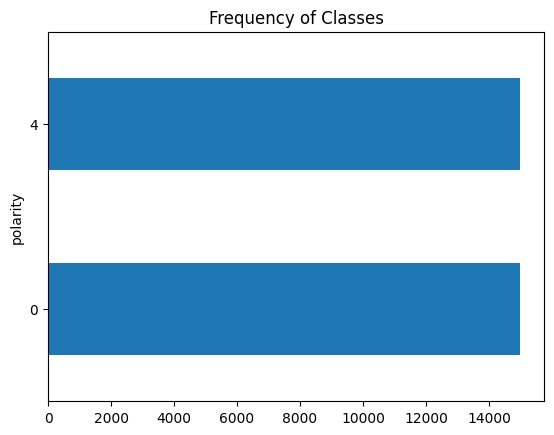

In [9]:
# Distribucion de instancias por clases (i.e. estrellas)

import matplotlib.pyplot as plt

df["polarity"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.rcParams['figure.figsize'] = [10, 80]
plt.show()

Vamos a dividir nuevamente el dataframe en tres y aleatorizar los conjuntos de datos, que estaban ordenados en función del número de estrellas.

In [10]:
import random
random.seed(0)

df_train = df[df['split'] == 'train'][['text', 'polarity']]
df_valid = df[df['split'] == 'dev'][['text', 'polarity']]
df_test = df[df['split'] == 'test'][['text', 'polarity']]

df_train = df_train.sample(frac=1)
df_valid = df_valid.sample(frac=1)
df_test = df_test.sample(frac=1)

Para agilizar el proceso de finetuning de nuestro modelo con el dataset, vamos a seleccionar el 10% del dataset de entrenamiento mismo respetando la distribución equilibrada de clases.

In [11]:
df_train

,text,polarity
24443,@TheShellyfish Every time I see you've posted ...,4
25764,sampai di kb already. gonna sleepover at alin's.,4
25684,http://twitpic.com/6p2b3 - @NancyHall @BenMack...,4
7926,#iremember when rugrats used to go on tv! i mi...,0
3071,ok so i made a background for my sister and it...,0
...,...,...
13670,Back to marking,0
7751,@the_carl Sounds like I missed a great time to...,0
5948,I cant take the hurt...,0
901,I think half my patients are healthier than I ...,0


In [12]:
df_train['polarity'] = df_train['polarity'].map({0: 0, 4: 1})
df_valid['polarity'] = df_valid['polarity'].map({0: 0, 4: 1})
df_test['polarity'] = df_test['polarity'].map({0: 0, 4: 1})

In [13]:
df_train

,text,polarity
24443,@TheShellyfish Every time I see you've posted ...,1
25764,sampai di kb already. gonna sleepover at alin's.,1
25684,http://twitpic.com/6p2b3 - @NancyHall @BenMack...,1
7926,#iremember when rugrats used to go on tv! i mi...,0
3071,ok so i made a background for my sister and it...,0
...,...,...
13670,Back to marking,0
7751,@the_carl Sounds like I missed a great time to...,0
5948,I cant take the hurt...,0
901,I think half my patients are healthier than I ...,0


Vamos a convertir los dataframes en datasets de HuggingFace, librería que vamos a utilizar para hacer aprendizaje transferido con un transformador. Intalaremos HuggingFace y la librería Dataset.

In [14]:
!pip install datasets

In [15]:
from datasets import Dataset, DatasetDict

dataset = DatasetDict({
    "train": Dataset.from_pandas(df_train.reset_index(drop=True)),
    "valid": Dataset.from_pandas(df_valid.reset_index(drop=True)),
     "test": Dataset.from_pandas(df_test.reset_index(drop=True))
    }
    )
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'polarity'],
        num_rows: 24000
    })
    valid: Dataset({
        features: ['text', 'polarity'],
        num_rows: 3000
    })
    test: Dataset({
        features: ['text', 'polarity'],
        num_rows: 3000
    })
})

In [16]:
dataset['train'][122]

{'text': '@bgblogging Sorry - caught a nasty stomach flu last night. Been in bed all day! Will have to be next time! ',
 'polarity': 0}

Vamos a preparar las etiquetas de las categorías de estrellas para poder usar el transformador.

La línea dataset = dataset.class_encode_column("stars") convierte los valores de la columna "stars" del dataset en etiquetas. Esto es necesario para que la función de pérdida "CrossEntropyLoss" de PyTorch pueda procesar los datos.

La línea labels = dataset['train'].features['stars'] obtiene un objeto "ClassLabel" que contiene la información de las etiquetas de clase del conjunto de entrenamiento.

La línea dataset = dataset.rename_column("stars", "label") renombra la columna "stars" del dataset a "label". Esto es necesario para que el conjunto de datos tenga una columna con el nombre esperado por el modelo de clasificación de secuencias de Hugging Face.

La línea print(labels.names) imprime los nombres de las etiquetas de clase del conjunto de entrenamiento.

In [17]:
dataset = dataset.class_encode_column("polarity")
dataset = dataset.rename_column("polarity", "label")
labels = dataset['train'].features['label']
print(labels.names)

Stringifying the column:   0%|          | 0/24000 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/24000 [00:00<?, ? examples/s]

Stringifying the column:   0%|          | 0/3000 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/3000 [00:00<?, ? examples/s]

Stringifying the column:   0%|          | 0/3000 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/3000 [00:00<?, ? examples/s]

['0', '1']


# Aprendizaje transferido con Transformadores

Vamos a utilizar la librería Transformers de Hugging Face para entrenar un modelo de clasificación de secuencias utilizando un modelo de transformador preentrenado.

Aquí hay una explicación detallada:

  1. Se importan varias clases y funciones de la librería Transformers de Hugging Face.
  2. Se asigna a la variable transformer_model el nombre de un modelo de transformador preentrenado.
  3. Se crea una instancia del tokenizador asociado al modelo de transformador especificado en la variable transformer_model.
  4. Se define una función tokenize que toma las instancias del dataset y tokeniza los textos utilizando el tokenizador del modelo cargado. Los parámetros truncation y padding son utilizados por el tokenizador de la librería Transformers para procesar los datos de entrada. truncation indica si se deben recortar los datos de entrada que superen un cierto límite de longitud. Si se establece en True, el tokenizador recortará los datos de entrada a la longitud máxima especificada y agregará una marca de final de secuencia (eos_token) al final del trozo recortado. Si se establece en False, el tokenizador devolverá un error si los datos de entrada exceden la longitud máxima especificada. padding se encargará de rellenar con 0 toda la secuencia hasta llegar a la longitud máxima de tokens por secuencia (512 para BERT y derivados).
  5. Se aplica la función tokenize al dataset usando el método map. El resultado se almacena en la variable ds.
  6. Se determina si hay una GPU disponible y, de ser así, se asigna a la variable device el dispositivo "cuda", de lo contrario se asigna "cpu".
  4. Se crea una instancia del modelo de transfomador especificado en la variable transformer_model, se establece el número de etiquetas en len(labels_classes) y se carga en el dispositivo especificado en la variable device.
  
   

La secuencia de entrada se divide en subpalabras usando un algoritmo (WordPiece, en el caso de BERT), lo que permite manejar palabras desconocidas y reducir el tamaño del vocabulario.

In [18]:
from transformers import AutoTokenizer
import torch

transformer_model = 'prajjwal1/bert-tiny'
tokenizer = AutoTokenizer.from_pretrained(transformer_model)

def tokenize(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)

ds = dataset.map(tokenize, batched=True)
ds

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/24000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 24000
    })
    valid: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3000
    })
})

In [19]:
from transformers import  AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained(transformer_model, num_labels=2).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
ds['train'][0]

{'text': "@TheShellyfish Every time I see you've posted to your blog, I think &quot;Yay! Something new in the fishbowl!&quot; I'm easily amused ",
 'label': 1,
 'input_ids': [101,
  1030,
  1996,
  4095,
  5349,
  2100,
  7529,
  2296,
  2051,
  1045,
  2156,
  2017,
  1005,
  2310,
  6866,
  2000,
  2115,
  9927,
  1010,
  1045,
  2228,
  1004,
  22035,
  2102,
  1025,
  8038,
  2100,
  999,
  2242,
  2047,
  1999,
  1996,
  3869,
  18912,
  2140,
  999,
  1004,
  22035,
  2102,
  1025,
  1045,
  1005,
  1049,
  4089,
  11770,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,

Las características input_ids y attention_mask son utilizadas para procesar los datos de entrada.


    'input_ids': una lista de números enteros que representan los índices de tokens del tweet en el vocabulario del tokenizador.
    'attention_mask': una lista de números binarios que indican qué tokens del tweet deben tener en cuenta al realizar el procesamiento.

Internamente, cuando pasamos los input_ids, que representan los tokens, al modelo, BERT los convierte en embeddings. Esto sucede dentro de la arquitectura del modelo pre-entrenado. Estos vectores se combinan con embeddings posicionales. Los embeddings se procesan a través de capas bidireccionales de Transformers que usan auto-atención para capturar relaciones entre palabras en toda la secuencia. Esta parte se maneja internamente en el modelo de BERT que hemos cargado. Cuando se llama a model(...), BERT procesa la entrada a través de sus múltiples capas de transformador.

Más adelante, el modelo de BERT extrae la representación del token [CLS] (a menudo accesible como pooler_output), y esa representación se utiliza en el cabezal de clasificación.
En el modelo pre-entrenado, esta representación se proyecta luego a través del cabezal de clasificación.

Definimos las métricas de evaluación mediante una función compute_metrics que se utiliza para calcular varias métricas de rendimiento para un modelo de clasificación. Esta función toma una tupla eval_pred como entrada y devuelve un diccionario con las métricas de rendimiento calculadas.

In [21]:
from sklearn.metrics import accuracy_score, f1_score
import numpy as np  # Asegúrate de importar numpy para poder usar np.argmax

# Definimos la función compute_metrics que recibirá un argumento 'eval_pred'
def compute_metrics(eval_pred):
    # Desempaquetamos 'eval_pred' en dos variables:
    # 'logits' son las salidas sin procesar (raw outputs) del modelo para cada ejemplo.
    # 'labels' son las etiquetas verdaderas correspondientes a esos ejemplos.
    logits, labels = eval_pred

    # Convertimos los logits en predicciones finales tomando el índice con el valor máximo a lo largo del eje de clases.
    # Este índice representa la clase predicha para cada ejemplo.
    predictions = np.argmax(logits, axis=-1) # axis=-1 porque tomamos el valor máximo de la última dimensión, es decir, la columna que representa las claswa

    # Calculamos la precisión (accuracy) comparando las etiquetas verdaderas con las predichas.
    acc = accuracy_score(labels, predictions)

    # Calculamos la puntuación F1 macro.
    # 'average="macro"' calcula la F1 para cada clase y luego toma el promedio sin ponderar, lo que permite ver el rendimiento general
    # considerando todas las clases de forma igualitaria.
    macro_f1 = f1_score(labels, predictions, average='macro')

    # Retornamos un diccionario con las métricas calculadas, que en este caso son "accuracy" y "macro_f1".
    return {"accuracy": acc, "macro_f1": macro_f1}


# Entrenamiento con distintos parámetros

Este código es utilizado para entrenar un modelo de transformadores utilizando la clase Trainer.

En primer lugar, se establecen algunos parámetros de entrenamiento, como el tamaño del lote, el nombre del modelo finetuned, el número de épocas de entrenamiento, la tasa de aprendizaje, la relación de calentamiento, la tasa de decaimiento del peso, la estrategia de evaluación, la estrategia de guardado, la métrica para el mejor modelo y la opción de cargar el mejor modelo al final del entrenamiento. Estos parámetros se almacenan en la variable training_args utilizando la clase TrainingArguments de transformers.

Luego se crea una instancia de la clase Trainer pasándole como argumentos el modelo, los parámetros de entrenamiento, la función de cálculo de métricas, el conjunto de datos de entrenamiento, el conjunto de datos de validación, el tokenizador y el DataCollator.

Por último, se llama al método train de la instancia del entrenador para iniciar el proceso de entrenamiento. Durante el entrenamiento, se calculará la pérdida de entrenamiento. Además, se calcularán las métricas de evaluación en el conjunto de datos de validación y se guardará el mejor modelo en función de la métrica especificada.

Para más info acerca de los parámetros que se pueden utilizar, consulta: https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments

#Entrenamiento modificando epochs y learning rate

## Entrenamiento con 5 epochs y 2e-5 de learning rate

In [ ]:
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding

batch_size = 16
model_name = "finetuned_model_sentiment_analysis"
training_args = TrainingArguments(
        output_dir=model_name,
        num_train_epochs=5,
        learning_rate = 2e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        warmup_ratio=0.1,
        weight_decay=0.01,
        eval_strategy="epoch",
        save_strategy="epoch",
        metric_for_best_model = "macro_f1",
        load_best_model_at_end=True,
        save_total_limit = 1,
        report_to='none',
    )

# Para algunos modelos que necesitan manejar secuencias de diversas longitudes
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=ds["train"],
                  eval_dataset=ds["valid"],
                  data_collator=data_collator
                  )
trainer.train()

Epoch,Training Loss,Validation Loss


Evaluamos el mejor modelo entrenado en el conjunto de prueba y obtenemos las métricas de evaluación.

In [ ]:
preds_output = trainer.predict(ds['test'])
print(preds_output.metrics)

Obtenemos el informe de clasificación global y detallado de las predicciones hechas por el mejor modelo en función de las clases.

In [ ]:
from sklearn.metrics import classification_report
# ------------------------------------------------------------------------------------
# Convertimos las etiquetas verdaderas del conjunto de test a un array de NumPy.
# ds['test']["label"] se asume que es la columna que contiene las etiquetas (targets)
# del dataset de prueba.
y_true = np.array(ds['test']["label"])

# ------------------------------------------------------------------------------------
# preds_output es un objeto que contiene las salidas del modelo al hacer predicciones
# sobre el conjunto de test. Normalmente, preds_output.predictions es un array de
# logits (valores sin procesar) de forma [n_ejemplos, n_clases].
#
# Con np.argmax(preds_output.predictions, axis=-1) obtenemos, para cada ejemplo,
# el índice de la clase con el mayor valor. Es decir, convertimos los logits en la clase
# predicha para cada muestra.
y_pred = preds_output.predictions.argmax(-1)

# target_names se usa para asignar nombres legibles a cada clase (por ejemplo, "positiva",
# "negativa", etc.), lo que facilita la interpretación del informe.
report = classification_report(
  y_true,          # Etiquetas reales del conjunto de test
  y_pred,          # Etiquetas predichas tras aplicar argmax a los logits del modelo
  target_names=labels.names,  # Lista de nombres correspondientes a cada etiqueta/clase
)
print(report)

## Entrenamiento con 3 epochs y 10e-5 de learning rate

In [ ]:
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding

batch_size = 16
model_name = "finetuned_model_sentiment_analysis"
training_args = TrainingArguments(
        output_dir=model_name,
        num_train_epochs=3,
        learning_rate = 10e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        warmup_ratio=0.1,
        weight_decay=0.01,
        eval_strategy="epoch",
        save_strategy="epoch",
        metric_for_best_model = "macro_f1",
        load_best_model_at_end=True,
        save_total_limit = 1,
        report_to='none',
    )

# Para algunos modelos que necesitan manejar secuencias de diversas longitudes
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=ds["train"],
                  eval_dataset=ds["valid"],
                  data_collator=data_collator
                  )
trainer.train()

Evaluamos el mejor modelo entrenado en el conjunto de prueba y obtenemos las métricas de evaluación.

In [ ]:
preds_output = trainer.predict(ds['test'])
print(preds_output.metrics)

Obtenemos el informe de clasificación global y detallado de las predicciones hechas por el mejor modelo en función de las clases.

In [ ]:
from sklearn.metrics import classification_report
# ------------------------------------------------------------------------------------
# Convertimos las etiquetas verdaderas del conjunto de test a un array de NumPy.
# ds['test']["label"] se asume que es la columna que contiene las etiquetas (targets)
# del dataset de prueba.
y_true = np.array(ds['test']["label"])

# ------------------------------------------------------------------------------------
# preds_output es un objeto que contiene las salidas del modelo al hacer predicciones
# sobre el conjunto de test. Normalmente, preds_output.predictions es un array de
# logits (valores sin procesar) de forma [n_ejemplos, n_clases].
#
# Con np.argmax(preds_output.predictions, axis=-1) obtenemos, para cada ejemplo,
# el índice de la clase con el mayor valor. Es decir, convertimos los logits en la clase
# predicha para cada muestra.
y_pred = preds_output.predictions.argmax(-1)

# target_names se usa para asignar nombres legibles a cada clase (por ejemplo, "positiva",
# "negativa", etc.), lo que facilita la interpretación del informe.
report = classification_report(
  y_true,          # Etiquetas reales del conjunto de test
  y_pred,          # Etiquetas predichas tras aplicar argmax a los logits del modelo
  target_names=labels.names,  # Lista de nombres correspondientes a cada etiqueta/clase
)
print(report)

## Entrenamiento con 5 epochs y 5e-5 de learning rate

In [ ]:
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding

batch_size = 16
model_name = "finetuned_model_sentiment_analysis"
training_args = TrainingArguments(
        output_dir=model_name,
        num_train_epochs=5,
        learning_rate = 5e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        warmup_ratio=0.1,
        weight_decay=0.01,
        eval_strategy="epoch",
        save_strategy="epoch",
        metric_for_best_model = "macro_f1",
        load_best_model_at_end=True,
        save_total_limit = 1,
        report_to='none',
    )

# Para algunos modelos que necesitan manejar secuencias de diversas longitudes
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=ds["train"],
                  eval_dataset=ds["valid"],
                  data_collator=data_collator
                  )
trainer.train()

Evaluamos el mejor modelo entrenado en el conjunto de prueba y obtenemos las métricas de evaluación.

In [ ]:
preds_output = trainer.predict(ds['test'])
print(preds_output.metrics)

Obtenemos el informe de clasificación global y detallado de las predicciones hechas por el mejor modelo en función de las clases.

In [ ]:
from sklearn.metrics import classification_report
# ------------------------------------------------------------------------------------
# Convertimos las etiquetas verdaderas del conjunto de test a un array de NumPy.
# ds['test']["label"] se asume que es la columna que contiene las etiquetas (targets)
# del dataset de prueba.
y_true = np.array(ds['test']["label"])

# ------------------------------------------------------------------------------------
# preds_output es un objeto que contiene las salidas del modelo al hacer predicciones
# sobre el conjunto de test. Normalmente, preds_output.predictions es un array de
# logits (valores sin procesar) de forma [n_ejemplos, n_clases].
#
# Con np.argmax(preds_output.predictions, axis=-1) obtenemos, para cada ejemplo,
# el índice de la clase con el mayor valor. Es decir, convertimos los logits en la clase
# predicha para cada muestra.
y_pred = preds_output.predictions.argmax(-1)

# target_names se usa para asignar nombres legibles a cada clase (por ejemplo, "positiva",
# "negativa", etc.), lo que facilita la interpretación del informe.
report = classification_report(
  y_true,          # Etiquetas reales del conjunto de test
  y_pred,          # Etiquetas predichas tras aplicar argmax a los logits del modelo
  target_names=labels.names,  # Lista de nombres correspondientes a cada etiqueta/clase
)
print(report)

## Entrenamiento con 10 epochs y 2e-5 de learning rate

In [ ]:
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding

batch_size = 16
model_name = "finetuned_model_sentiment_analysis"
training_args = TrainingArguments(
        output_dir=model_name,
        num_train_epochs=10,
        learning_rate = 2e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        warmup_ratio=0.1,
        weight_decay=0.01,
        eval_strategy="epoch",
        save_strategy="epoch",
        metric_for_best_model = "macro_f1",
        load_best_model_at_end=True,
        save_total_limit = 1,
        report_to='none',
    )

# Para algunos modelos que necesitan manejar secuencias de diversas longitudes
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=ds["train"],
                  eval_dataset=ds["valid"],
                  data_collator=data_collator
                  )
trainer.train()

Evaluamos el mejor modelo entrenado en el conjunto de prueba y obtenemos las métricas de evaluación.

In [ ]:
preds_output = trainer.predict(ds['test'])
print(preds_output.metrics)

Obtenemos el informe de clasificación global y detallado de las predicciones hechas por el mejor modelo en función de las clases.

In [ ]:
from sklearn.metrics import classification_report
# ------------------------------------------------------------------------------------
# Convertimos las etiquetas verdaderas del conjunto de test a un array de NumPy.
# ds['test']["label"] se asume que es la columna que contiene las etiquetas (targets)
# del dataset de prueba.
y_true = np.array(ds['test']["label"])

# ------------------------------------------------------------------------------------
# preds_output es un objeto que contiene las salidas del modelo al hacer predicciones
# sobre el conjunto de test. Normalmente, preds_output.predictions es un array de
# logits (valores sin procesar) de forma [n_ejemplos, n_clases].
#
# Con np.argmax(preds_output.predictions, axis=-1) obtenemos, para cada ejemplo,
# el índice de la clase con el mayor valor. Es decir, convertimos los logits en la clase
# predicha para cada muestra.
y_pred = preds_output.predictions.argmax(-1)

# target_names se usa para asignar nombres legibles a cada clase (por ejemplo, "positiva",
# "negativa", etc.), lo que facilita la interpretación del informe.
report = classification_report(
  y_true,          # Etiquetas reales del conjunto de test
  y_pred,          # Etiquetas predichas tras aplicar argmax a los logits del modelo
  target_names=labels.names,  # Lista de nombres correspondientes a cada etiqueta/clase
)
print(report)

De todas las combinaciones de número de epochs y learning rate que hemos probado, nos quedamos con la opción de 3 epochs y de 10e-5 de learning rate, ya que es la que nos ha dado mejores resultados. De hecho, en este caso, tanto la f1-score de la accuracy como la correspondiente a la macro avg y a la weighted avg ofrecen un resultado de 0.50.

#Entrenamiento modificando weight decay

## Entrenamiento con 3 epochs, 10e-5 de learning rate y weight decay de 0.01

In [ ]:
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding

batch_size = 16
model_name = "finetuned_model_sentiment_analysis"
training_args = TrainingArguments(
        output_dir=model_name,
        num_train_epochs=3,
        learning_rate = 10e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        warmup_ratio=0.1,
        weight_decay=0.01,
        eval_strategy="epoch",
        save_strategy="epoch",
        metric_for_best_model = "macro_f1",
        load_best_model_at_end=True,
        save_total_limit = 1,
        report_to='none',
    )

# Para algunos modelos que necesitan manejar secuencias de diversas longitudes
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=ds["train"],
                  eval_dataset=ds["valid"],
                  data_collator=data_collator
                  )
trainer.train()

Evaluamos el mejor modelo entrenado en el conjunto de prueba y obtenemos las métricas de evaluación.

In [ ]:
preds_output = trainer.predict(ds['test'])
print(preds_output.metrics)

Obtenemos el informe de clasificación global y detallado de las predicciones hechas por el mejor modelo en función de las clases.

In [ ]:
from sklearn.metrics import classification_report
# ------------------------------------------------------------------------------------
# Convertimos las etiquetas verdaderas del conjunto de test a un array de NumPy.
# ds['test']["label"] se asume que es la columna que contiene las etiquetas (targets)
# del dataset de prueba.
y_true = np.array(ds['test']["label"])

# ------------------------------------------------------------------------------------
# preds_output es un objeto que contiene las salidas del modelo al hacer predicciones
# sobre el conjunto de test. Normalmente, preds_output.predictions es un array de
# logits (valores sin procesar) de forma [n_ejemplos, n_clases].
#
# Con np.argmax(preds_output.predictions, axis=-1) obtenemos, para cada ejemplo,
# el índice de la clase con el mayor valor. Es decir, convertimos los logits en la clase
# predicha para cada muestra.
y_pred = preds_output.predictions.argmax(-1)

# target_names se usa para asignar nombres legibles a cada clase (por ejemplo, "positiva",
# "negativa", etc.), lo que facilita la interpretación del informe.
report = classification_report(
  y_true,          # Etiquetas reales del conjunto de test
  y_pred,          # Etiquetas predichas tras aplicar argmax a los logits del modelo
  target_names=labels.names,  # Lista de nombres correspondientes a cada etiqueta/clase
)
print(report)

## Entrenamiento con 3 epochs, 10e-5 de learning rate y weight decay de 0.05

In [ ]:
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding

batch_size = 16
model_name = "finetuned_model_sentiment_analysis"
training_args = TrainingArguments(
        output_dir=model_name,
        num_train_epochs=3,
        learning_rate = 10e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        warmup_ratio=0.1,
        weight_decay=0.05,
        eval_strategy="epoch",
        save_strategy="epoch",
        metric_for_best_model = "macro_f1",
        load_best_model_at_end=True,
        save_total_limit = 1,
        report_to='none',
    )

# Para algunos modelos que necesitan manejar secuencias de diversas longitudes
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=ds["train"],
                  eval_dataset=ds["valid"],
                  data_collator=data_collator
                  )
trainer.train()

Evaluamos el mejor modelo entrenado en el conjunto de prueba y obtenemos las métricas de evaluación.

In [ ]:
preds_output = trainer.predict(ds['test'])
print(preds_output.metrics)

Obtenemos el informe de clasificación global y detallado de las predicciones hechas por el mejor modelo en función de las clases.

In [ ]:
from sklearn.metrics import classification_report
# ------------------------------------------------------------------------------------
# Convertimos las etiquetas verdaderas del conjunto de test a un array de NumPy.
# ds['test']["label"] se asume que es la columna que contiene las etiquetas (targets)
# del dataset de prueba.
y_true = np.array(ds['test']["label"])

# ------------------------------------------------------------------------------------
# preds_output es un objeto que contiene las salidas del modelo al hacer predicciones
# sobre el conjunto de test. Normalmente, preds_output.predictions es un array de
# logits (valores sin procesar) de forma [n_ejemplos, n_clases].
#
# Con np.argmax(preds_output.predictions, axis=-1) obtenemos, para cada ejemplo,
# el índice de la clase con el mayor valor. Es decir, convertimos los logits en la clase
# predicha para cada muestra.
y_pred = preds_output.predictions.argmax(-1)

# target_names se usa para asignar nombres legibles a cada clase (por ejemplo, "positiva",
# "negativa", etc.), lo que facilita la interpretación del informe.
report = classification_report(
  y_true,          # Etiquetas reales del conjunto de test
  y_pred,          # Etiquetas predichas tras aplicar argmax a los logits del modelo
  target_names=labels.names,  # Lista de nombres correspondientes a cada etiqueta/clase
)
print(report)

## Entrenamiento con 3 epochs, 10e-5 de learning rate y weight decay de 0.1

In [ ]:
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding

batch_size = 16
model_name = "finetuned_model_sentiment_analysis"
training_args = TrainingArguments(
        output_dir=model_name,
        num_train_epochs=3,
        learning_rate = 10e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        warmup_ratio=0.1,
        weight_decay=0.1,
        eval_strategy="epoch",
        save_strategy="epoch",
        metric_for_best_model = "macro_f1",
        load_best_model_at_end=True,
        save_total_limit = 1,
        report_to='none',
    )

# Para algunos modelos que necesitan manejar secuencias de diversas longitudes
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=ds["train"],
                  eval_dataset=ds["valid"],
                  data_collator=data_collator
                  )
trainer.train()

Evaluamos el mejor modelo entrenado en el conjunto de prueba y obtenemos las métricas de evaluación.

In [ ]:
preds_output = trainer.predict(ds['test'])
print(preds_output.metrics)

Obtenemos el informe de clasificación global y detallado de las predicciones hechas por el mejor modelo en función de las clases.

In [ ]:
from sklearn.metrics import classification_report
# ------------------------------------------------------------------------------------
# Convertimos las etiquetas verdaderas del conjunto de test a un array de NumPy.
# ds['test']["label"] se asume que es la columna que contiene las etiquetas (targets)
# del dataset de prueba.
y_true = np.array(ds['test']["label"])

# ------------------------------------------------------------------------------------
# preds_output es un objeto que contiene las salidas del modelo al hacer predicciones
# sobre el conjunto de test. Normalmente, preds_output.predictions es un array de
# logits (valores sin procesar) de forma [n_ejemplos, n_clases].
#
# Con np.argmax(preds_output.predictions, axis=-1) obtenemos, para cada ejemplo,
# el índice de la clase con el mayor valor. Es decir, convertimos los logits en la clase
# predicha para cada muestra.
y_pred = preds_output.predictions.argmax(-1)

# target_names se usa para asignar nombres legibles a cada clase (por ejemplo, "positiva",
# "negativa", etc.), lo que facilita la interpretación del informe.
report = classification_report(
  y_true,          # Etiquetas reales del conjunto de test
  y_pred,          # Etiquetas predichas tras aplicar argmax a los logits del modelo
  target_names=labels.names,  # Lista de nombres correspondientes a cada etiqueta/clase
)
print(report)

Para determinar el mejor parámetro para la weight decay, empezamos estableciendo como constantes el número de epochs (3) y el learning rate (10e-5) basándonos en los resultados obtenidos en las pruebas anteriores. De esta manera, sabiendo que estos números son los que nos han ofrecido mejores resultados, probamos las tres opciones de weight decay que nos interesan: 0.01, 0.05 y 0.1. De estas tres posibilidades, nos quedamos con la de 0.01 por ser la que ofrece  mejores resultados.

Para probar distintas combinaciones de parámetros, he seguido una metodología sistemática y coherente comprobando primero las variaciones de los epochs y el learning rate para así quedarme con la opción que mejores resultados ofrece. Definidos así los primeros parámetros, podemos pasar al weight decay y probar también todas sus opciones manteniendo estables los parámetros ya definidos.

Durante el proceso de entrenamiento del modelo basado en un transformador, he evaluado distintas configuraciones para encontrar la combinación óptima teniendo en cuenta los siguientes factores: número de épocas, learning rate y weight decay. Después del experimento nos quedamos con 3 épocas, el learning rate de 10e-5 y el weight decay de 0.01, ya que son los que mejores resultados nos han dado hasta ahora. De hecho, conseguimos una f1-score de 0.48 tanto para accuracy como para macro avg y weighted avg. Este es el mejor resultado que hemos obtenido de todas las combinaciones que hemos probado.

Durante la fase de ajuste de hiperparámetros, se han evaluado distintas combinaciones de número de épocas y tasa de aprendizaje para optimizar el rendimiento del modelo de transformadores. Para ello, se han probado tres combinaciones: 3 épocas y LR de 10e-5, 5 épocas y LR de 5e-5, y 10 épocas y LR de 2e-5. Para justificar las combinaciones seleccionadas debemos tener en cuenta que cuando el número de epochs es reducido es recomendable utilizar un learning rate más alto para que el modelo pueda aprender de forma más rápida y efectiva en menos pasos de optimización. En cambio, al aumentar el número de epochs, suele ser necesario reducir el learning rate para evitar que el modelo realice cambios demasiado bruscos en los pesos, permitiendo un ajuste más fino y estable.

La combinación de 3 epochs con un learning rate de 10e-5 nos ha ofrecido los mejores resultados en comparación con configuraciones de entrenamiento más largas y learning rates más bajos. En este caso, la configuración de 3 epochs con un learning rate de 10e-5 nos ha permitido alcanzar un buen equilibrio entre velocidad de aprendizaje y calidad del ajuste de los pesos.

Posteriormente, he estudiado el efecto del weight decay utilizando los valores 0.01, 0.05 y 0.1. El valor de 0.01 es el que nos ha proporcionado el mejor rendimiento. Aunque la función del weight decay es prevenir el sobreajuste penalizando los pesos grandes, valores de regularización demasiado altos (como 0.05 o 0.1) pueden limitar la capacidad del modelo para ajustarse a los datos, como ocurre en estos casos en los que el modelo ha funcionado peor al augmentar el weight decay.